In [344]:
#This notebook is used to predict the calories burnt through regression, SVM and boosting algos

import pandas as pd 
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.svm import SVR 
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [345]:
exercise = pd.read_csv('../input/kaggle/exercise.csv')
exercise.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


In [346]:
calories = pd.read_csv('../input/kaggle/calories.csv')
calories.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [347]:
df = pd.merge(left=exercise, right=calories)
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [348]:
df

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...,...
14995,15644082,female,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,17212577,female,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,17271188,female,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,18643037,male,78,193.0,97.0,2.0,84.0,38.3,11.0


In [349]:
df.dtypes

User_ID         int64
Gender         object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object

In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [351]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [352]:
df.corr(numeric_only=True)

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
User_ID,1.000000,-0.001827,-0.013520,-0.011603,-0.002751,-0.000457,0.000923,-0.001661
Age,-0.001827,1.000000,0.009554,0.090094,0.013247,0.010482,0.013175,0.154395
Height,-0.013520,0.009554,1.000000,0.958451,-0.004625,0.000528,0.001200,0.017537
Weight,-0.011603,0.090094,0.958451,1.000000,-0.001884,0.004311,0.004095,0.035481
Duration,-0.002751,0.013247,-0.004625,-0.001884,1.000000,0.852869,0.903167,0.955421
Heart_Rate,-0.000457,0.010482,0.000528,0.004311,0.852869,1.000000,0.771529,0.897882
Body_Temp,0.000923,0.013175,0.001200,0.004095,0.903167,0.771529,1.000000,0.824558
Calories,-0.001661,0.154395,0.017537,0.035481,0.955421,0.897882,0.824558,1.000000


In [353]:
df.iloc[:,1:]

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,female,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...
14995,female,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,female,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,female,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,male,78,193.0,97.0,2.0,84.0,38.3,11.0


In [354]:
corr_mat = df.corr(numeric_only=True)
corr_mat['Calories'].sort_values(ascending=False)

Calories      1.000000
Duration      0.955421
Heart_Rate    0.897882
Body_Temp     0.824558
Age           0.154395
Weight        0.035481
Height        0.017537
User_ID      -0.001661
Name: Calories, dtype: float64

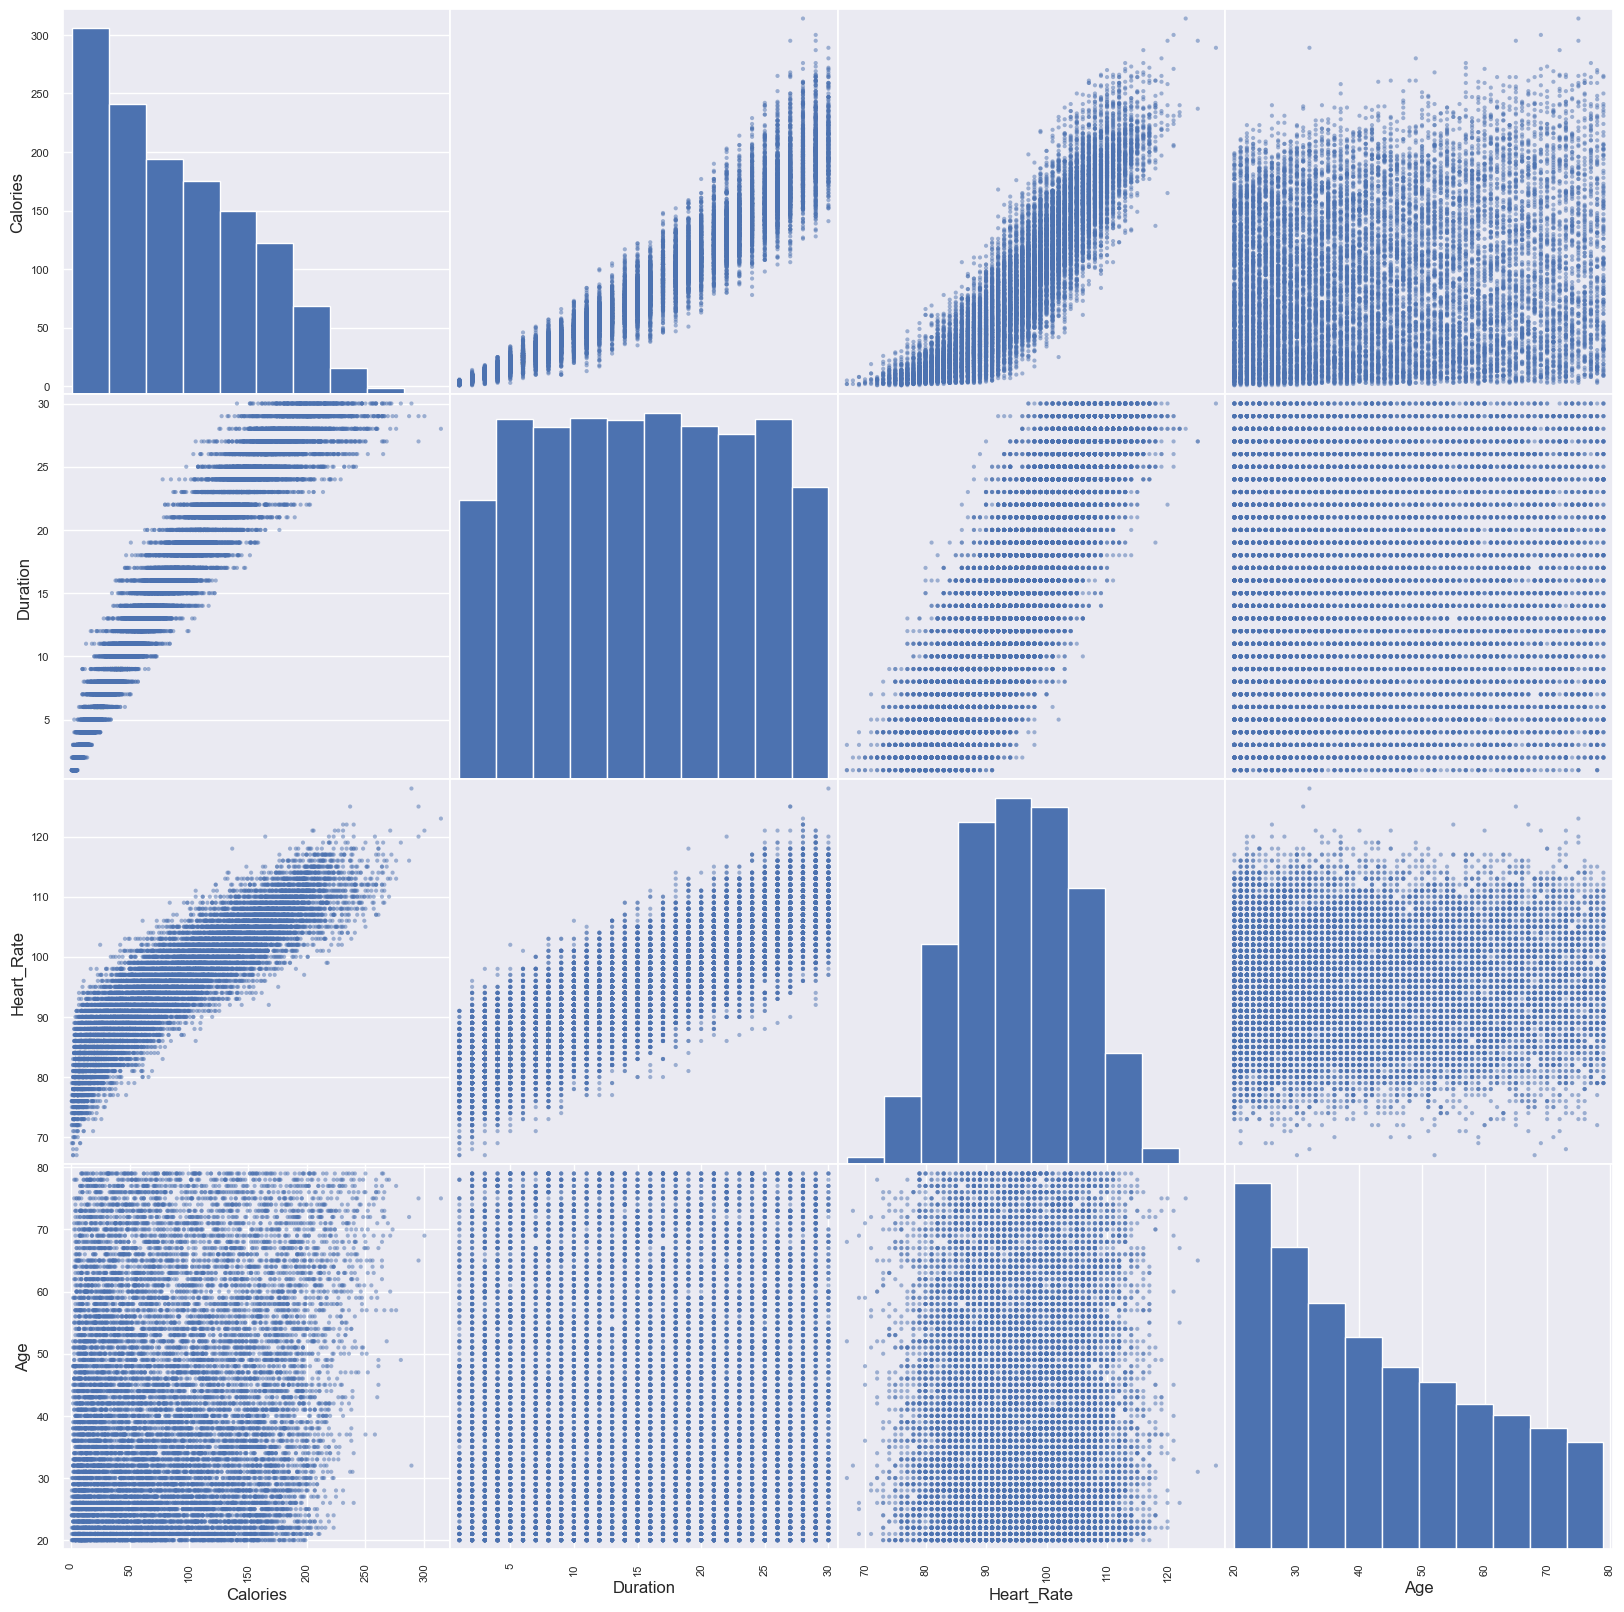

In [355]:
attributes = ['Calories', 'Duration', 'Heart_Rate', 'Age']
pd.plotting.scatter_matrix(df[attributes],figsize=(20,20))
plt.show()

In [356]:
ordinalencoder = OrdinalEncoder()
df[['Gender']] = ordinalencoder.fit_transform(df[['Gender']])
df

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,1.0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,0.0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,1.0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,0.0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,0.0,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...,...
14995,15644082,0.0,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,17212577,0.0,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,17271188,0.0,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,18643037,1.0,78,193.0,97.0,2.0,84.0,38.3,11.0


In [357]:
df = df.values
df

array([[1.4733363e+07, 1.0000000e+00, 6.8000000e+01, ..., 1.0500000e+02,
        4.0800000e+01, 2.3100000e+02],
       [1.4861698e+07, 0.0000000e+00, 2.0000000e+01, ..., 9.4000000e+01,
        4.0300000e+01, 6.6000000e+01],
       [1.1179863e+07, 1.0000000e+00, 6.9000000e+01, ..., 8.8000000e+01,
        3.8700000e+01, 2.6000000e+01],
       ...,
       [1.7271188e+07, 0.0000000e+00, 4.3000000e+01, ..., 9.0000000e+01,
        4.0100000e+01, 7.5000000e+01],
       [1.8643037e+07, 1.0000000e+00, 7.8000000e+01, ..., 8.4000000e+01,
        3.8300000e+01, 1.1000000e+01],
       [1.1751526e+07, 1.0000000e+00, 6.3000000e+01, ..., 9.2000000e+01,
        4.0500000e+01, 9.8000000e+01]])

In [358]:
X, y = df[:,1:-1], df[:,-1]

In [359]:
test_size = 0.2
seed = 42

In [360]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=test_size, random_state=seed)

In [361]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
pred = lin_reg.predict(X_validation)
rmse = np.sqrt(mean_squared_error(y_validation, pred))
rmse

11.488940149152933

In [362]:
svr = SVR()
svr.fit(X_train, y_train)
pred = svr.predict(X_validation)
rmse = np.sqrt(mean_squared_error(y_validation, pred))
rmse

15.969950373627778

In [363]:
dec_reg = DecisionTreeRegressor()
dec_reg.fit(X_train, y_train)
pred = dec_reg.predict(X_validation)
rmse = np.sqrt(mean_squared_error(y_validation, pred))
rmse

5.270388979952049

In [364]:
ada_reg = AdaBoostRegressor()
ada_reg.fit(X_train, y_train)
pred = ada_reg.predict(X_validation)
rmse = np.sqrt(mean_squared_error(y_validation, pred))
rmse

11.982855081583233

In [365]:
gra_reg = GradientBoostingRegressor()
gra_reg.fit(X_train, y_train)
pred = gra_reg.predict(X_validation)
rmse = np.sqrt(mean_squared_error(y_validation, pred))
rmse

3.612132078825045

In [366]:
for_reg = RandomForestRegressor()
for_reg.fit(X_train, y_train)
pred = for_reg.predict(X_validation)
rmse = np.sqrt(mean_squared_error(y_validation, pred))
rmse

2.659270094092237

In [367]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
pred = xgbr.predict(X_validation)
rmse = np.sqrt(mean_squared_error(y_validation, pred))
rmse

2.1375116634132594

In [368]:
num_folds = 10
seed = 42
scoring = 'neg_mean_squared_error'

In [369]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN',ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

In [370]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f'{name}:({sqrt(-cv_results.mean())},{cv_results.std()})')

LR:(11.278548739803737,5.6594032921495145)
LASSO:(11.755780115286479,6.814899226509233)
EN:(12.373888509816895,7.524224139039464)
KNN:(7.45523373208379,3.4984590858786193)
CART:(5.440519276686739,2.7695167912371366)
SVR:(16.022333155537485,23.287464853176598)


In [371]:
ensembles = []
ensembles.append(('ADABOOST', AdaBoostRegressor()))
ensembles.append(('GRADIENT BOOST', GradientBoostingRegressor()))
ensembles.append(('RANDOM FOREST ',RandomForestRegressor()))
ensembles.append(('EXTRA TREES', ExtraTreesRegressor()))
ensembles.append(('XGB',XGBRegressor()))

In [372]:
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model,X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f'{name}:({sqrt(-cv_results.mean())},{cv_results.std()})')

ADABOOST:(11.720305732084288,5.587583745525224)
GRADIENT BOOST:(3.7348913349693516,0.9081436619329178)
RANDOM FOREST :(2.9291648454238053,1.0828012250644095)
EXTRA TREES:(2.4191713741485947,0.6808616155891014)
XGB:(2.221714289936276,0.7893088358097703)
